# Chapter 4 Data preprocessing
## 4.1 Know your data

In [57]:
# Imports
import os
from pathlib import Path
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from statsmodels.distributions.empirical_distribution import ECDF


In [41]:
DATA_PATH = "../data/data_ml.csv"
data_ml = pd.read_csv(DATA_PATH)
data_ml['date'] = pd.to_datetime(data_ml['date'])
data_ml.head()

,stock_id,date,Advt_12M_Usd,Advt_3M_Usd,Advt_6M_Usd,Asset_Turnover,Bb_Yld,Bv,Capex_Ps_Cf,Capex_Sales,...,Total_Capital,Total_Debt,Total_Debt_Capital,Total_Liabilities_Total_Assets,Vol1Y_Usd,Vol3Y_Usd,R1M_Usd,R3M_Usd,R6M_Usd,R12M_Usd
0,13,2006-12-31,0.25,0.33,0.27,0.22,0.33,0.01,0.13,0.84,...,0.02,0.27,1.0,0.92,0.84,0.88,0.089,0.104,0.344,-0.041
1,13,2007-01-31,0.25,0.32,0.28,0.22,0.40,0.01,0.13,0.84,...,0.02,0.27,1.0,0.92,0.84,0.88,0.039,0.091,-0.011,-0.253
2,13,2007-02-28,0.26,0.30,0.30,0.22,0.15,0.01,0.13,0.84,...,0.02,0.27,1.0,0.92,0.87,0.88,-0.012,0.101,0.118,-0.366
3,17,2015-03-31,0.73,0.64,0.70,0.40,0.47,0.01,0.70,0.74,...,0.40,0.75,1.0,1.00,1.00,0.99,0.174,-0.144,-0.518,-0.376
4,17,2015-04-30,0.72,0.62,0.66,0.40,0.46,0.01,0.70,0.74,...,0.40,0.75,1.0,1.00,1.00,0.99,-0.106,-0.576,-0.535,-0.113


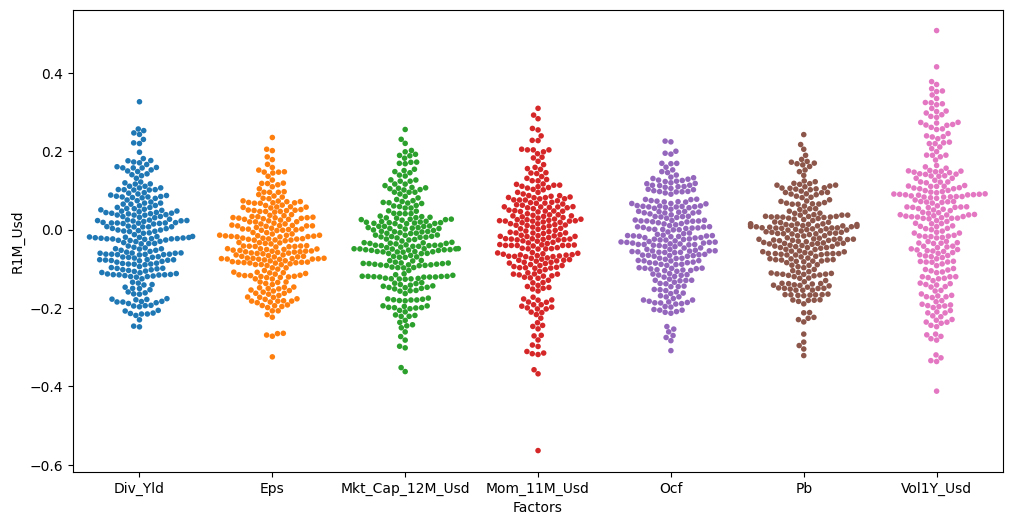

In [42]:
features=list(data_ml.iloc[:,3:95].columns) # Keep the features' column names
features_short =["Div_Yld", "Eps", "Mkt_Cap_12M_Usd", "Mom_11M_Usd", "Ocf", "Pb", "Vol1Y_Usd"]

cols= features_short+['R1M_Usd','date'] # Keep few features, label & dates
data_corr = data_ml[cols]               # Creating the working dataset
data_corr = data_corr.groupby('date').corr()[['R1M_Usd']].reset_index() # Group for computing correlation
data_corr= data_corr.loc[data_corr[data_corr.level_1.str[-7:] != "R1M_Usd"].index] # removing correl=1 instances from label
data_corr.rename(columns={'level_1': "Factors"},inplace=True) # Renaming for plotting later
plt.figure(figsize=(12,6))              # resizing the chart
sns.swarmplot(x="Factors", y="R1M_Usd", data=data_corr, size=4, hue="Factors", legend=False);

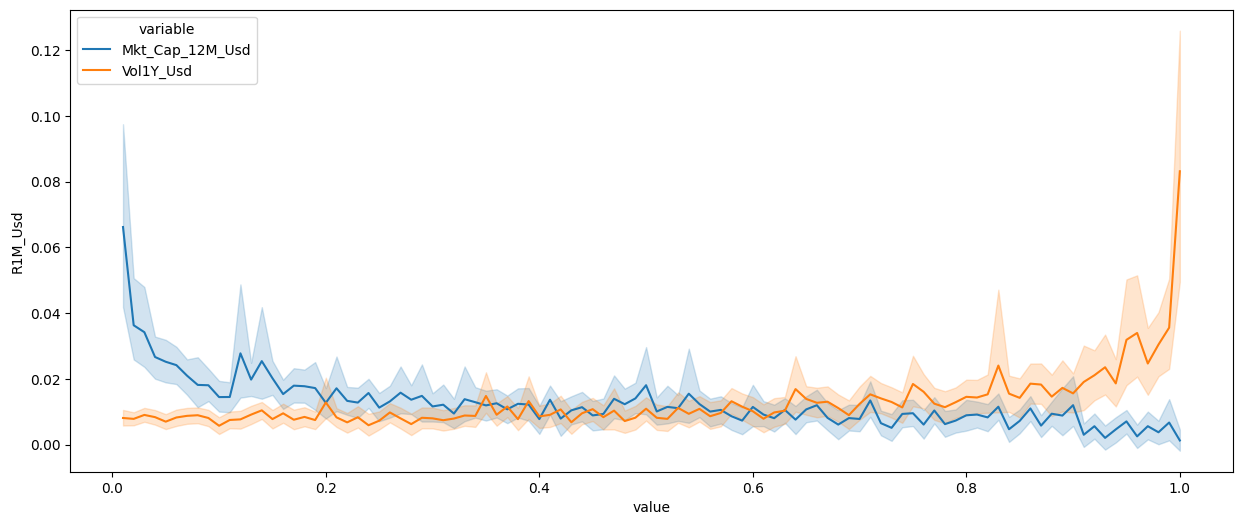

In [43]:
unpivoted_data_ml = pd.melt(data_ml[['R1M_Usd','Mkt_Cap_12M_Usd','Vol1Y_Usd']], id_vars='R1M_Usd') # selecting and putting in vector
plt.figure(figsize=(15,6))
sns.lineplot(data = unpivoted_data_ml, y='R1M_Usd', x='value', hue='variable'); # Plot from seaborn

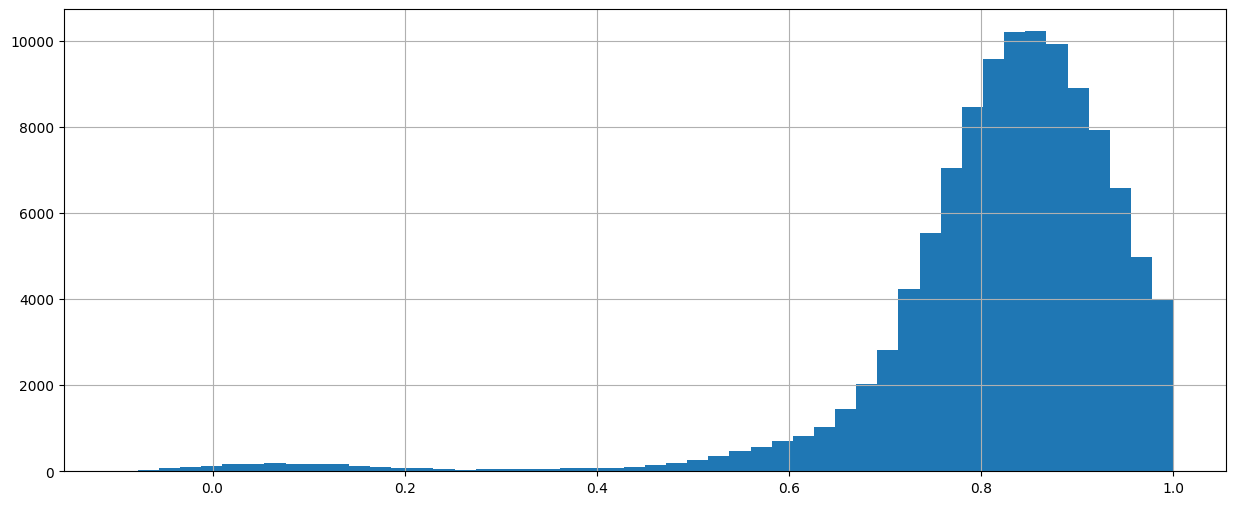

In [44]:
cols=[]                                 # cleaning the column list from previous use
cols = ['stock_id'] + list(data_ml.iloc[:,3:95].columns) # Keep all features and stockid

# Compute autocorrelation, filtering out invalid values
with warnings.catch_warnings():
    warnings.filterwarnings('ignore', category=RuntimeWarning)
    data_hist_acf = pd.melt(data_ml[cols], id_vars='stock_id').groupby(['stock_id','variable'], group_keys=False).apply(
        lambda x: x['value'].autocorr(lag=1), include_groups=False
    )

# Remove NaN and inf values before plotting
data_hist_acf = data_hist_acf.replace([np.inf, -np.inf], np.nan).dropna()

plt.figure(figsize=(15,6))
data_hist_acf.hist(bins=50, range=[-0.1,1]); # Plot from pandas

## 4.8 Additional code and results
### 4.8.1 Impact of rescaling: graphical representation

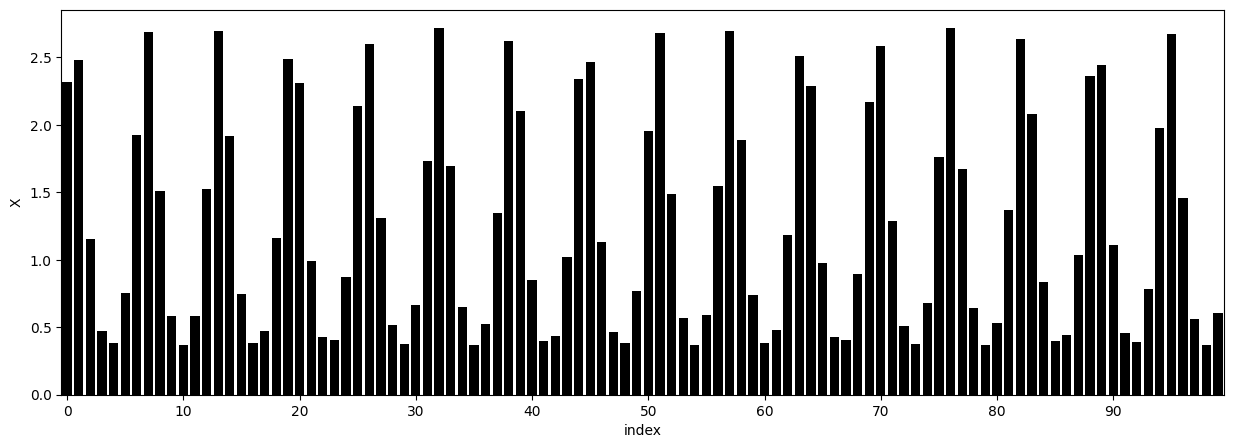

In [45]:
length = 100
x = np.exp(np.sin(np.linspace(1,length,length)))
data = pd.DataFrame(data=x,columns=['X'])
data.reset_index(inplace=True)
plt.figure(figsize=(15,5)) # resizing figure
sns.barplot(y="X", data=data, x="index", color='black'); # Plot from Seaborn
plt.xticks(data['index'][::10]);   # reshape the xtick every 10 observations

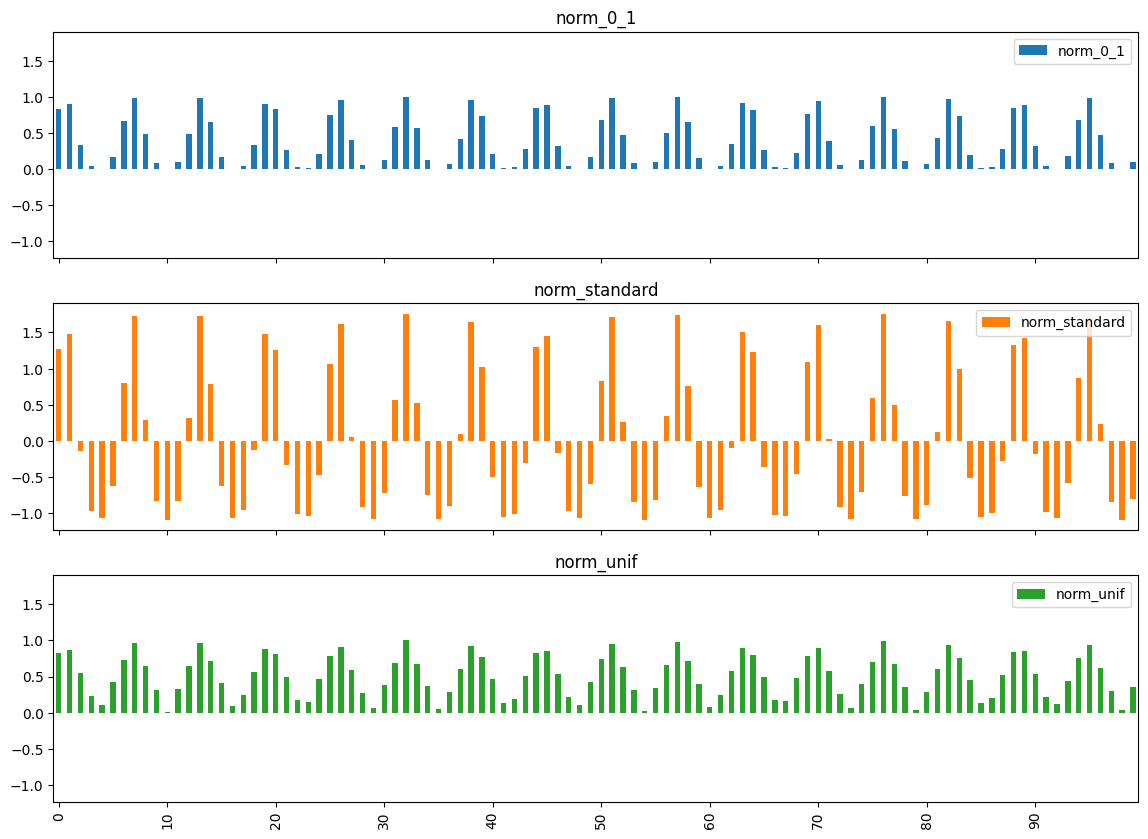

In [46]:
def norm_0_1(x):
    return (x-np.min(x))/(np.max(x)-np.min(x))
def norm_unif(x):
    return (ECDF(x)(x))
def norm_standard(x):
    return (x- np.mean(x))/np.std(x)

data_norm=pd.DataFrame.from_dict(dict( # ensembling numpy arrays into a dict and then a pd dataframe
index=np.linspace(1,length,length), # creating the index
norm_0_1=norm_0_1(x), # normalisation [0,1]
norm_standard=norm_standard(x), # standardisation
norm_unif=norm_unif(x))) # Uniformisation
data_norm.iloc[:,1:4].plot.bar( figsize=(14,10), subplots=True, sharey=True, sharex=True); # Plot
plt.xticks(data['index'][::10]);   # reshape the xtick every 10 observations

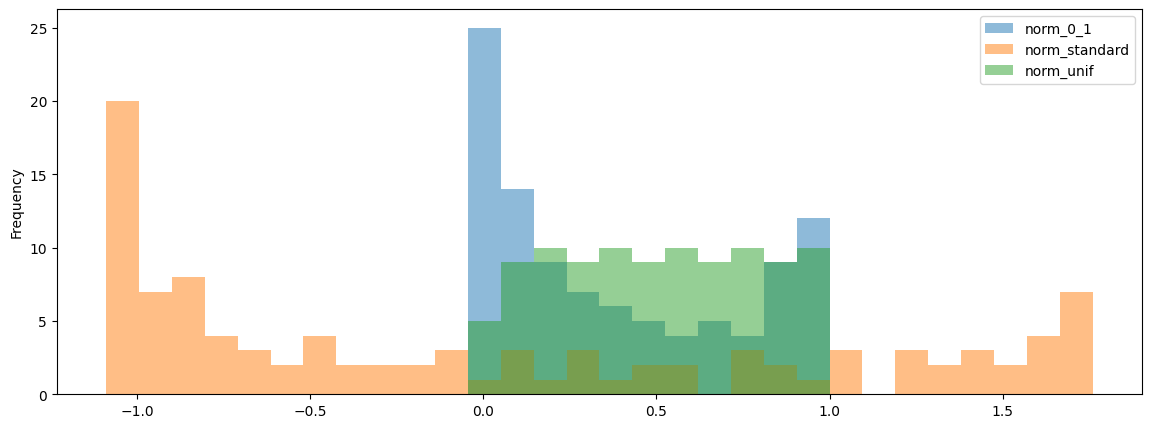

In [47]:
data_norm.iloc[:,1:4].plot.hist(alpha=0.5, bins=30, figsize=(14,5)); # Plot from pandas, alphas=opacity

### 4.8.2 Impact of rescaling: toy example

In [52]:
cap=np.array([10,50,100, # Market capitalization
              15,10,15,
              200,120,80])
returns=np.array([0.06,0.01,-0.06, # Return values
        -0.03,0.00,0.02,
        -0.04,-0.02,0.00])
date=np.array([1,2,3,1,2,3,1,2,3]) # Dates
firm=np.array([1,1,1,2,2,2,3,3,3]) # Firms (3 lines for each)
toy_data=pd.DataFrame.from_dict(dict(firm=firm,date=date,cap=cap,returns=returns, # Aggregation of data
cap_norm=norm_0_1(cap),
cap_u=norm_unif(cap))) 
toy_data

,firm,date,cap,returns,cap_norm,cap_u
0,1,1,10,0.06,0.000000,0.222222
1,1,2,50,0.01,0.210526,0.555556
2,1,3,100,-0.06,0.473684,0.777778
3,2,1,15,-0.03,0.026316,0.444444
4,2,2,10,0.00,0.000000,0.222222
5,2,3,15,0.02,0.026316,0.444444
6,3,1,200,-0.04,1.000000,1.000000
7,3,2,120,-0.02,0.578947,0.888889
8,3,3,80,0.00,0.368421,0.666667


In [59]:
X=toy_data.cap_norm.to_numpy()
X=sm.add_constant(X)
model = sm.OLS(returns, X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.379
Model:                            OLS   Adj. R-squared:                  0.290
Method:                 Least Squares   F-statistic:                     4.265
Date:                Tue, 02 Dec 2025   Prob (F-statistic):             0.0778
Time:                        18:08:06   Log-Likelihood:                 19.892
No. Observations:                   9   AIC:                            -35.78
Df Residuals:                       7   BIC:                            -35.39
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0124      0.014      0.912      0.392      -0.020       0.045
x1            -0.0641      0.031     -2.065      0.078      -0.137       0.009
==============================================================================
Omnibus:                        0.200   Durbin-Watson:                   0.872
Prob(Omnibus):                  0.905   Jarque-Bera (JB):                0.152
Skew:                          -0.187   Prob(JB):                        0.927
Kurtosis:                       2.485   Cond. No.                         3.40
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [60]:
X=toy_data.cap_u.to_numpy()
X=sm.add_constant(X)
model = sm.OLS(returns, X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.488
Model:                            OLS   Adj. R-squared:                  0.415
Method:                 Least Squares   F-statistic:                     6.672
Date:                Tue, 02 Dec 2025   Prob (F-statistic):             0.0363
Time:                        18:10:28   Log-Likelihood:                 20.764
No. Observations:                   9   AIC:                            -37.53
Df Residuals:                       7   BIC:                            -37.13
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0457      0.022      2.056      0.079      -0.007       0.098
x1            -0.0902      0.035     -2.583      0.036      -0.173      -0.008
==============================================================================
Omnibus:                        1.603   Durbin-Watson:                   0.918
Prob(Omnibus):                  0.449   Jarque-Bera (JB):                0.895
Skew:                          -0.428   Prob(JB):                        0.639
Kurtosis:                       1.715   Cond. No.                         5.20
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## 4.9 Coding exercices

In [ ]:
# 1. The Federal Reserve of Saint Louis (https://fred.stlouisfed.org) hosts thousands of time series of economic indicators that can serve as conditioning variables.
# Pick one and apply formula (4.3) to expand the number of predictors. If need be, use the function defined above.
from fredapi import Fred

fred = Fred(api_key='903cee46f18a62c7f32f877e692dcd9c')
ip_data = fred.get_series('INDPRO')

ip_data

TypeError: 'Fred' object is not callable